

---


# Instalación de dependencias


---



Google Colaboraty tiene ya configurado el uso de Tensorflow, se pueden utilizar una de las dos versiones de tensorflow con el comando 'mágico':


*   *%tensorflow_version 1.x* para la versión 1 de Tensorflow


In [ ]:
# Selección de versión de tensorflow para Google Colaboratory
%tensorflow_version 2.x

# Instalación de tqdm, barras de progreso en python
!pip install tqdm

In [ ]:
# Consulta de la versión instalada para tensorflow
!pip list | grep tensorflow

tensorflow                    2.6.0
tensorflow-datasets           4.0.1
tensorflow-estimator          2.6.0
tensorflow-gcs-config         2.6.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.2.0
tensorflow-probability        0.14.1




---


# Importación de librerias


---



In [ ]:
# Conexión con google dirve, donde se tiene el dataset
from google.colab import drive

import os                           # Para las direcciones del OS
import zipfile                      # Para descomprimir
import numpy as np                  # Para el uso de arrays compatibles con TF
import matplotlib.pyplot as plt     # Muestra de gráficas
import seaborn as sns               # Para mostrar la matriz de confusión

# Construcción de la matriz de confusión y reporte 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Preparar un flujo de imagenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Construcción de la cabecera personalizada de la CNN
from tensorflow.keras.layers import Dropout, Dense, Flatten
# Optimizador de perdida
from tensorflow.keras import optimizers
# Modelo pre-entrenado
from tensorflow.keras.applications import VGG19
# Construcción del modelo con nuestra nueva cabecera
from tensorflow.keras.models import Model
# Función de perdida variable
from tensorflow.keras.optimizers.schedules import ExponentialDecay



---


# Carga de datos

---



## Montaje de google drive, donde se tiene almacenado el dataset

Si desea descargarse el dataset se puede obtener atraves del siguiente enlace: [DA_data](https://drive.google.com/uc?id=1JwvKbohJ1m2kqZrsaU1oN32zUdhNY-x4&export=download)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Descomprimir el dataset

El dataset se encuentra en formato zip, por lo cual se debe descomprimir.
Se descomprime y en la carpeta principal, para Google Colaboraty es en la carpeta '/content'.

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/DA_datav2_2.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./DA")
zip_object.close()



---


# Declaración de variables


---



In [ ]:
# Dirección donde se encuentra el dataset
data_dir = '/content/DA'

# Total de imagenes por ccategoría
total_images_DA = len(os.listdir(data_dir+"/DA"))
total_images_NoDA = len(os.listdir(data_dir+"/NoDA"))

# Total de imagenes
total_images = total_images_DA + total_images_NoDA

# Porción del dataset que sera utilizado para validación
validation_split = 0.15

# Tamaño de la imagen, las imagenes serán cuadradas
image_size = 224

# Tamaño de las muestras que se tomarán para el entrenamiento
batch_size_train = 128

# Tamaño de las muestras que se tomarán para la validación
batch_size_validation = 64

# Tamaño de imagen que recibira la CNN 
input_shape = (image_size, image_size, 3)

# Epochs de entrenamiento
epochs = 10

# Radio de aprendizaje inicial
initial_learning_rate = 5e-3

# Valor a partir del cual se carácteriza como DA
threshold = 0.5

## Radio de aprendizaje variable

El radio de aprendizaje es una de los parametros que utilizan las funciones de optimización, entre mayor sea el valor se verán cambios mñas grandes en la diferencia de perdida entre cada paso, entre menor sea las diferencias serán menores.

Crearemos un valor de radio de aprendizaje variable, este decrementara con el paso del tiempo, se configura con un valor inicial de 5e-3 y que cada 180 pasos sufra una perdida del 70% de su valor.

> Ejemplo con valor inicial de lr = 1, perdida del 90% cada 300 pasos

Paso    | lr
--------|----------
0       | 1
300     | 0.1
600     | 0.01
900     | 1e-3

In [ ]:
learning_rate = ExponentialDecay(
    initial_learning_rate,
    decay_steps=180,
    decay_rate=0.3,
    staircase=True)



---


# Generadores de datos


---



In [ ]:
# Imagenes para el entrenamiento
# Las imagenes que sean cargadas serán preprocesadas por lo siguiente
data_Generator = ImageDataGenerator(
    rotation_range=10,      # Un rotación aleatoria de 0 a 10 grados
    rescale=1./255,         # Un reescalado de sus valores de 255-0 a 1-0
    shear_range=0.1,        # Corte aleatorio en lo bordes de hasta un 10%
    zoom_range=0.1,         # Zoom aleatorio de hasta un 10%
    horizontal_flip=True,   # Posible giro en horizontal
    width_shift_range=0.1,  # Recorrimiento de la imagen hasta un 10% , ancho
    height_shift_range=0.1, # Recorrimiento de la imagen hasta un 10% , alto
    validation_split=validation_split   # Segmento de validación
)

# Imagenes para un testing post-entrenamiento
exam_Generator = ImageDataGenerator(rescale=1./255)



---


# Flujo de datos atraves de un generador


---



## Flujo de imágenes de entrenamiento

In [ ]:
train_generator = data_Generator.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size_train,
    class_mode='binary',
    subset='training'
)

Found 4750 images belonging to 2 classes.


## Flujo de imágenes de validación

In [ ]:
validation_generator = data_Generator.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size_validation,
    class_mode='binary',
    subset='validation'
)

Found 837 images belonging to 2 classes.


## Flujo de imágenes de testing

In [ ]:
example_generator = exam_Generator.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    class_mode='binary',
    batch_size=1024
)

x_val = example_generator[0][0] # Imagenes del generador, imagenes a predecir
y_val = example_generator[0][1] # Valores objetivo

Found 5587 images belonging to 2 classes.


## Función para desplegar imágenes muestra

In [ ]:
def plotImagesExample(images, y_target, vals, labels, default="--"):
  plt.figure(figsize=(12, 12))
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(images[i])
      xlabel_ = default
      for x in range(len(labels)):
        if (y_target[i]==vals[x]):
          xlabel_ = labels[x]
          break 
      plt.xlabel(xlabel_)
  plt.tight_layout()
  plt.show()

## Ejemplo de imagenes de entrenamiento

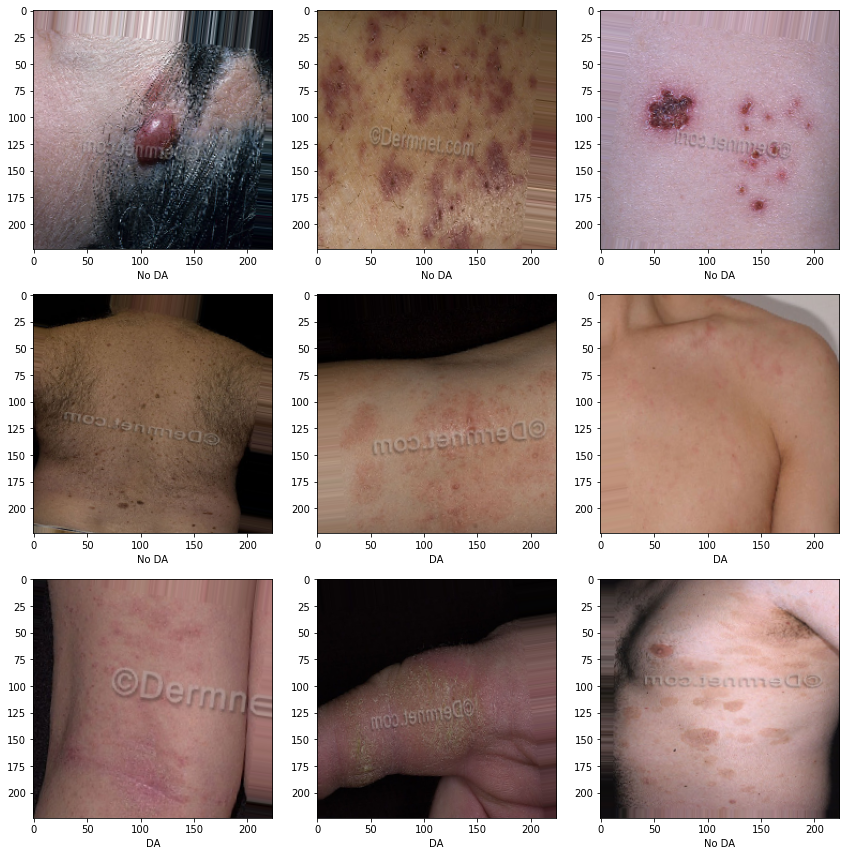

In [ ]:
plotImagesExample(train_generator[0][0], train_generator[0][1], [0.,1.], ['DA', 'No DA'])



---


# Funciones importantes

---



Para el desarrollo del modelo, su entrenamiento, evaluación y muestra de resultados implementaremos las siguientes funciones.
Se realizan con el fin de reutilizar código.



## Función para compilar el modelo

In [ ]:
# model     - Modelo al que se le aplicarán las operaciones
# loss      - Función de perdida que se implementará 
# lr        - Learning rate, valor default 1e-3
# numLayers - Número de capas, apartir de la ultima que se usarán para el 
#             entrenamiento, el resto del modelo quedará congelado

def compileModel(model, loss, lr=1e-3, numLayers=None):
  # Descongelar el modelo completo
  model.trainable = True

  # Congelar las capas del modelo que se usarán para entrenar
  if numLayers!=None:
    for layer in model.layers[:-numLayers]:
      layer.trainable = False

  # Compilar el modelo
  model.compile(loss=loss,
                optimizer=optimizers.SGD(learning_rate=lr, momentum=0.9),
                metrics=['accuracy'])

## Función para entrenar el modelo

In [ ]:
# model       - Modelo al que se le aplicarán las operaciones
# epochs      - Numero de epocas a entrenar
# train       - Conjunto de entranamiento
# validation  - Conjunto de validación

def modelFit(model, epochs,train,validation):
  return model.fit(
      train,
      epochs=epochs,
      validation_data=validation,
      workers=2)

## Función de evaluación del modelo

In [ ]:
# model   - Modelo a evaluar
# data    - Datos con los cuales se efectuará la evaluación

def evaluateModel(model, data):
  loss, accuracy = model.evaluate(x=data, workers=8)
  print("Test: accuracy = %.3f  ;  loss = %.3f " % (accuracy, loss))

## Función Matriz de confusión

In [ ]:
def displayMatrixConfusion(val, pred, labels=None):
  # compute the confusion matrix
  confusion_mtx = confusion_matrix(val, pred, labels=labels)
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

## Función de reporte

In [ ]:
def displayReport(val, final, labels=None, target_names=None):  
  report = classification_report(val, final, labels=labels, target_names=target_names, zero_division=0)
  print(report)

## Función para gráficar el historial del entrenamiento

In [ ]:
# model_history   - Historial que retorna el entrenamiento
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    a = np.arange(1,len(model_history.history[acc])+1)
    axs[0].set_xticks(a)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    a = np.arange(1,len(model_history.history['loss'])+1)
    axs[1].set_xticks(a)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

---

# Construcción del Modelo


---



## Carga del modelo pre-entrenado *VGG19*, sin cabecera



In [ ]:
pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")

## Definir la cabecera personalizada

In [ ]:
last_output = pre_trained_model.output        # shape(None,7,7,512)
    
# Cada imágen 2-D pasa a un array 1-D, utilizando el promedio global
x = Flatten()(last_output)     # shape(None,25088)

# Se tiene una capa completamente conectada de 2048 nodos
x = Dense(2048, activation='relu')(x)         # shape(None,2048)

# Se tiene una capa parcialmente conectada de 1280 nodos, se hará un corte del 
# 25% de las conexiones totales, se hace con el fin de que las neuronas no sean 
# complementamente dependientes unas de las otras
x = Dropout(0.25)(x)                           # shape(None,2048)

# Capa de salida completamente conectada, de 1 nodo.
x = Dense(1, activation='sigmoid')(x)         # shape(None,1)


# Creación de un nuevo modelo, con la entrada del modelo pre-entrenado
# y las capas de la nueva cabecera
model = Model(pre_trained_model.input, x)

## Compilar el modelo

Debemos asegurar que el modelo se creo de forma correcta

In [ ]:
compileModel(model, 'binary_crossentropy', learning_rate)


---

# Transfer Learning

---


## Compilar el modelo

Solo se modificarán los pesos de las ultimas 4 capas, son las capas personalizadas que agregamos. 

In [ ]:
compileModel(model, 'binary_crossentropy', learning_rate, 4)

## Entrenamiento

In [ ]:
history = modelFit(model, epochs*2, train_generator, validation_generator)

Epoch 1/20
38/38 [==============================] - 158s 2s/step - loss: 1.1023 - accuracy: 0.5240 - val_loss: 0.6714 - val_accuracy: 0.6022
Epoch 2/20
38/38 [==============================] - 102s 3s/step - loss: 0.6660 - accuracy: 0.5956 - val_loss: 0.6400 - val_accuracy: 0.6798
Epoch 3/20
38/38 [==============================] - 101s 3s/step - loss: 0.6342 - accuracy: 0.6459 - val_loss: 0.6287 - val_accuracy: 0.6452
Epoch 4/20
38/38 [==============================] - 100s 3s/step - loss: 0.6157 - accuracy: 0.6703 - val_loss: 0.6030 - val_accuracy: 0.7168
Epoch 5/20
38/38 [==============================] - 100s 3s/step - loss: 0.6242 - accuracy: 0.6543 - val_loss: 0.6072 - val_accuracy: 0.6918
Epoch 6/20
38/38 [==============================] - 102s 3s/step - loss: 0.5977 - accuracy: 0.6853 - val_loss: 0.6020 - val_accuracy: 0.6834
Epoch 7/20
38/38 [==============================] - 102s 3s/step - loss: 0.5857 - accuracy: 0.7013 - val_loss: 0.5889 - val_accuracy: 0.7180
Epoch 8/20
38

## Evaluación del modelo, con el conjunto de validación

In [ ]:
evaluateModel(model, validation_generator)

14/14 [==============================] - 15s 543ms/step - loss: 0.5680 - accuracy: 0.7300
Test: accuracy = 0.730  ;  loss = 0.568 


## Información del entrenamiento

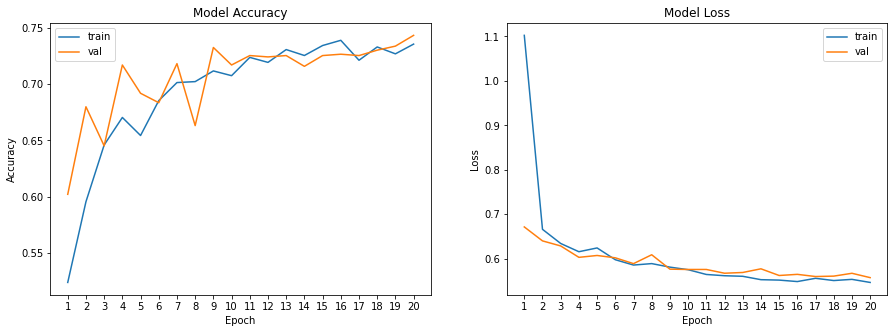

In [ ]:
plot_model_history(history)

## Predicción del modelo con una parte del set sin procesado, solo reescalado

In [ ]:
y_pred =  model.predict(x_val)

## Información de la predicción

### Preparar lo valores para su interpretación

In [ ]:
# (DA=0,NoDA=1), probabilidad > 0.5
y_DAVal = np.where(y_val == 1., 1., 0.)
y_DAPred = np.where(y_pred[:,0] > threshold, 1., 0.)

### Matriz de confusión

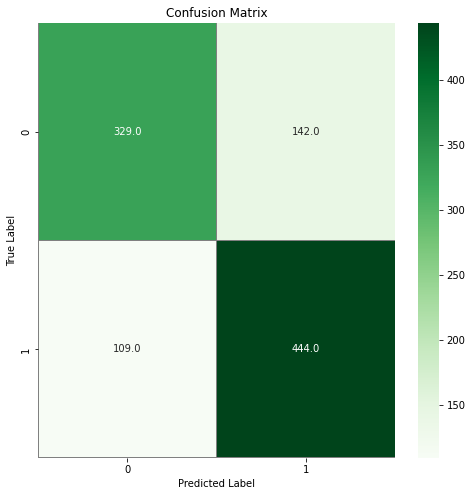

In [ ]:
displayMatrixConfusion(y_DAVal,y_DAPred, [0.,1.])

### Reporte

In [ ]:
displayReport(y_DAVal, y_DAPred, [0.,1.], ['DA','No DA'])

              precision    recall  f1-score   support

          DA       0.75      0.70      0.72       471
       No DA       0.76      0.80      0.78       553

    accuracy                           0.75      1024
   macro avg       0.75      0.75      0.75      1024
weighted avg       0.75      0.75      0.75      1024




---

# Guardado del modelo obtenido tras el Transfer Learning


---



In [ ]:
model.save('DA_VGG19_TransferLearning.h5')


---

# Fine Tuning

---


## Compilar el modelo

Solo se modificarán los pesos de las ultimas 7 capas, son las 4 capas personalizadas que agregamos y las ultimas 3 del modelo MobileNetV2 sin cabecera.

In [ ]:
compileModel(model, 'binary_crossentropy', learning_rate, 9)

## Entrenamiento

In [ ]:
history = modelFit(model, epochs*2, train_generator, validation_generator)

Epoch 1/20
38/38 [==============================] - 102s 3s/step - loss: 0.6992 - accuracy: 0.5434 - val_loss: 0.6931 - val_accuracy: 0.4600
Epoch 2/20
38/38 [==============================] - 99s 2s/step - loss: 0.6758 - accuracy: 0.5699 - val_loss: 0.6391 - val_accuracy: 0.6547
Epoch 3/20
38/38 [==============================] - 97s 2s/step - loss: 0.6240 - accuracy: 0.6503 - val_loss: 0.5837 - val_accuracy: 0.7145
Epoch 4/20
38/38 [==============================] - 99s 3s/step - loss: 0.5836 - accuracy: 0.6994 - val_loss: 0.5519 - val_accuracy: 0.7264
Epoch 5/20
38/38 [==============================] - 99s 3s/step - loss: 0.5772 - accuracy: 0.6983 - val_loss: 0.5087 - val_accuracy: 0.7503
Epoch 6/20
38/38 [==============================] - 100s 3s/step - loss: 0.4717 - accuracy: 0.7722 - val_loss: 0.5034 - val_accuracy: 0.7599
Epoch 7/20
38/38 [==============================] - 103s 3s/step - loss: 0.4969 - accuracy: 0.7577 - val_loss: 0.4736 - val_accuracy: 0.7742
Epoch 8/20
38/38 

## Evaluación del modelo, con el conjunto de validación

In [ ]:
evaluateModel(model, validation_generator)

14/14 [==============================] - 15s 580ms/step - loss: 0.4550 - accuracy: 0.7897
Test: accuracy = 0.790  ;  loss = 0.455 


## Información del entrenamiento

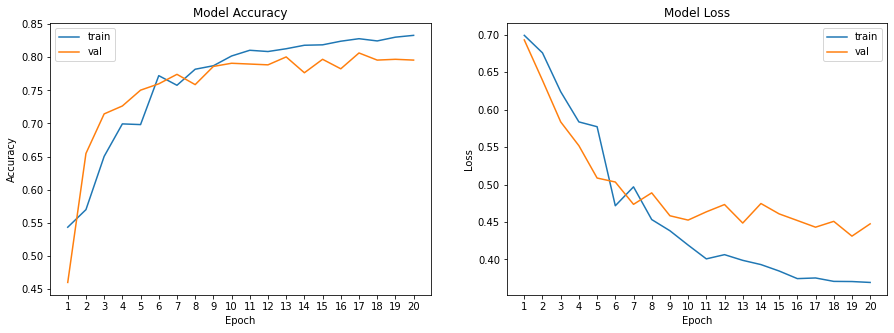

In [ ]:
plot_model_history(history)

## Predicción del modelo con una parte del set sin procesado, solo reescalado

In [ ]:
y_pred =  model.predict(x_val)

## Información de la predicción

### Preparar lo valores para su interpretación

In [ ]:
# (DA=0,NoDA=1), probabilidad > 0.5
y_DAVal = np.where(y_val == 1., 1., 0.)
y_DAPred = np.where(y_pred[:,0] > threshold, 1., 0.)

### Matriz de confusión

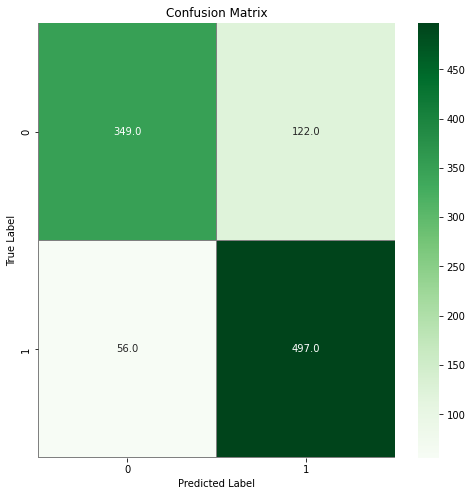

In [ ]:
displayMatrixConfusion(y_DAVal,y_DAPred, [0.,1.])

### Reporte

In [ ]:
displayReport(y_DAVal, y_DAPred, [0.,1.], ['DA','No DA'])

              precision    recall  f1-score   support

          DA       0.86      0.74      0.80       471
       No DA       0.80      0.90      0.85       553

    accuracy                           0.83      1024
   macro avg       0.83      0.82      0.82      1024
weighted avg       0.83      0.83      0.82      1024




---

# Guardado del modelo obtenido tras el Fine Tuning


---



In [ ]:
model.save('DA_VGG19_FineTuning.h5')